In [42]:
import unidecode
import string
import random
import re
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch.autograd import Variable

In [48]:
all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('../shakespeare.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 1115394


In [4]:
chunk_len = 200

In [5]:
def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

In [6]:
print(random_chunk())

ercutio's breast,
Who all as hot, turns deadly point to point,
And, with a martial scorn, with one hand beats
Cold death aside, and with the other sends
It back to Tybalt, whose dexterity,
Retorts it: 


In [23]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [24]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

In [25]:
def random_training_set():
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [26]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [27]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [40]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, torch.LongTensor([target[c]]))

    loss.backward()
    decoder_optimizer.step()

    return loss.data / chunk_len

In [41]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 11s (100 5%) 2.4931]
Whemnou weente hage the sting, I an pooncoudd ding soot of lof sereftearous fand ald att? in ind fir d 

 23s (200 10%) 2.3867]
What wirt my his wies fakd her gand iniess
Fom what he you hay a fordh yud, of ang!

COLIS:
And ak is  

 35s (300 15%) 1.9217]
Whand me a wigh what your,
So my my, the on wane who a wele thinge that thics hous sith if my, and cef 

 47s (400 20%) 2.1060]
Whad cond, of dere of the bore,
Thou rear as the, anter weill dispity hele am you
To do the prowned an 

 59s (500 25%) 1.8369]
Whet?

KING HININCENGET:

PARD ISI I Lent saculing.

RilICIUS:
Thall tees Rour angee, not must your co 

 11s (600 30%) 2.1256]
Whall sid wo, now fellow and greanciseme
With him are saut hendressen he sture then weet:
Bontend sear 

 23s (700 35%) 1.7589]
Whis the contentle, and suble as face have
ny, but kin thoust good sour, ay stay to kintionk thoun the 

 36s (800 40%) 2.0664]
What not in and way,
Ale thell your love cajarke; and the dimper drikeceds as proc

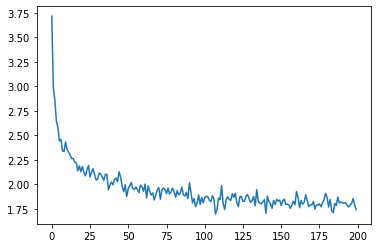

In [43]:
plt.figure()
plt.plot(all_losses)

In [44]:
print(evaluate('Th', 200, temperature=0.2))

The say the grace the grace.

COMINIUS:
Or the good the good he shall may the gods.

COMINIUS:
The to my love the was the good the good the good the like the good the good
The shall be her should word s


In [46]:
print(evaluate('Th', 200, temperature=0.8))

The gart?

COMINIUS:
The his the what did drissewert word;
The way, he where be you, look my there I his by
Our gartha, thy for of Houch him borks a good the again
We less my not strake ouses math.

RAT


In [45]:
print(evaluate('Th', 200, temperature=1.4))

Thage, you, ble-swill so; Inder she bloote
whippitet, muianss; my framega; oughr opcide rismburfen! unshing
The not my letty, my fing satcijes envruetis He alrec seced.
Thockn, in, csoring oplse neustic
